# Super-Long Stationary Run
Trolley at 99.03 deg, under station 22.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import allantools

from root_to_pandas import root_to_pandas
import trfp
import gm2

import helper_function_candidates as helper
import plotting_functions as plt2

from IPython.display import clear_output

ImportError: No module named root_to_pandas

## Import the long stationary runs
Have to interpolate the times between run numbers

In [ ]:
# %%time
# interp_df = root_to_pandas([7780], prefix='v9_24_00_dev2/FieldPlainRootOutput_', tr_run=True)

# for run in range(7781, 7794)+range(7795, 7825):  # no 7794 yet
#     clear_output()
#     print 'Run: '+str(run)+' of 7825'
#     temp_df = root_to_pandas([run], prefix='v9_24_00_dev2/FieldPlainRootOutput_', tr_run=True)
#     fill_times = np.arange(interp_df.index.values[-1]+1, temp_df.index.values[0])
#     fill_df = pd.DataFrame(index=fill_times, columns=interp_df.columns)

#     for col in interp_df.columns:
#         fill_df[col] = np.interp(fill_times, np.append(interp_df.index.values, temp_df.index.values),
#                                  np.append(interp_df[col].values, temp_df[col].values))

#     interp_df = interp_df.append(fill_df)
#     interp_df = interp_df.append(temp_df)

# interp_df['tr_phi'] = 99.03

# interp_df.to_hdf('super-long_stationary_run.h5', 'interp_df')


In [2]:
interp_df = pd.read_hdf('hdf5/super-long_stationary_run.h5', 'interp_df')

In [3]:
moment_df = pd.DataFrame(index=interp_df.index)
moment_df['tr_phi'] = interp_df['tr_phi'].values

print 'Calculating trolley moments.',
theta_tr = trfp.THETA_TR
for m in np.arange(17):
    tr_probes = ['tr'+str(probe) for probe in np.arange(17)]
    moment_df['tr,m'+str(m+1)] = interp_df[tr_probes].dot(theta_tr[m])
    
for station in np.arange(72):
    print '\rCalculating station ' + str(station) + ' moments.',
    fp_st = ['fp'+str(fp) for fp in trfp.STATION_PROBE_ID[station]]

    # choose proper theta matrix
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        if station == 41:
            theta_fp = trfp.THETA_FP_4_ST41
        elif (station == 37) | (station == 39):
            theta_fp = trfp.THETA_FP_4_ST37_ST39
        else:
            theta_fp = trfp.THETA_FP_4
    else:
        theta_fp = trfp.THETA_FP_6

    # step through m values
    for m in np.arange(len(trfp.STATION_PROBE_ID[station])):
        stm = 'st'+str(station)+',m'+str(m+1)
        moment_df[stm] = interp_df[fp_st].dot(theta_fp[m])
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        moment_df['st'+str(station)+',m5'] = np.nan
        moment_df['st'+str(station)+',m6'] = np.nan
        
# calculate baselines using the first 5 points (doesn't actually matter)
tr_baseline = np.empty((72,17))

df_mean =  np.mean(moment_df.iloc[0:1000], axis=0).values

for i in range(72):
    tr_baseline[i, :] = df_mean[1:18]
fp_baseline = np.reshape(df_mean[18:], (72,6))

baseline_time_1 = np.empty((72,6))
baseline_time_2 = np.empty((72,6))

baseline_time_1[:,:] = moment_df.index.values[0]
baseline_time_2[:,:] = moment_df.index.values[-1]

fp_df = moment_df.copy()

fp_df = fp_df.drop(columns=['tr_phi']+['tr,m'+str(m) for m in range(1,18)])

vtm_df = helper.vtm_calc(fp_df, baseline_time_1, baseline_time_2, tr_baseline, tr_baseline, fp_baseline, fp_baseline)

Calculating station 71 moments.                         


## Begin performing Allan studies on super-long run

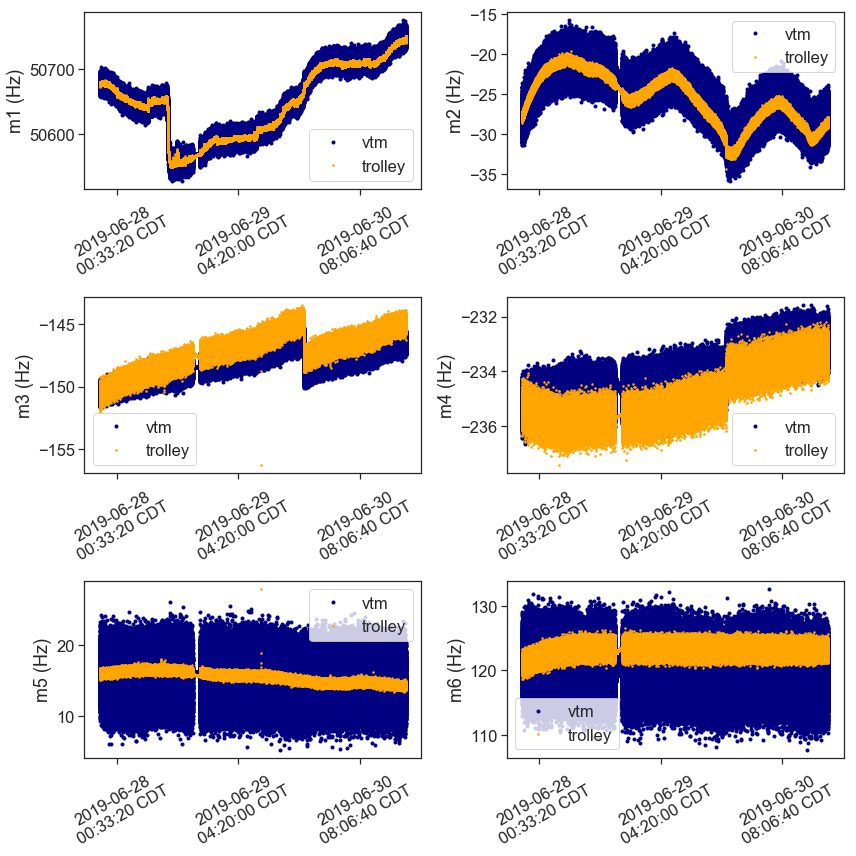

In [6]:
st = 22

fig, axs = plt.subplots(3,2)
for ii in range(2):
    for jj in range(3):
        m = 2*jj+ii+1
        trm = 'tr,m'+str(m)
        stm = 'st'+str(st)+',m'+str(m)
        plt.sca(axs[jj,ii])
        plt.plot(vtm_df.index.values, vtm_df[stm], '.', color='navy', label='vtm')
        plt.plot(moment_df.index.values, moment_df[trm], '.', color='orange', markersize=3, label='trolley')
        plt2.plt_unix_time_to_CST(axs[jj,ii])
        plt2.plt_set_labels(axs[jj,ii], '', 'm'+str(m)+' (Hz)', '')
        plt.legend()
fig.set_size_inches(12,12)
fig.tight_layout()

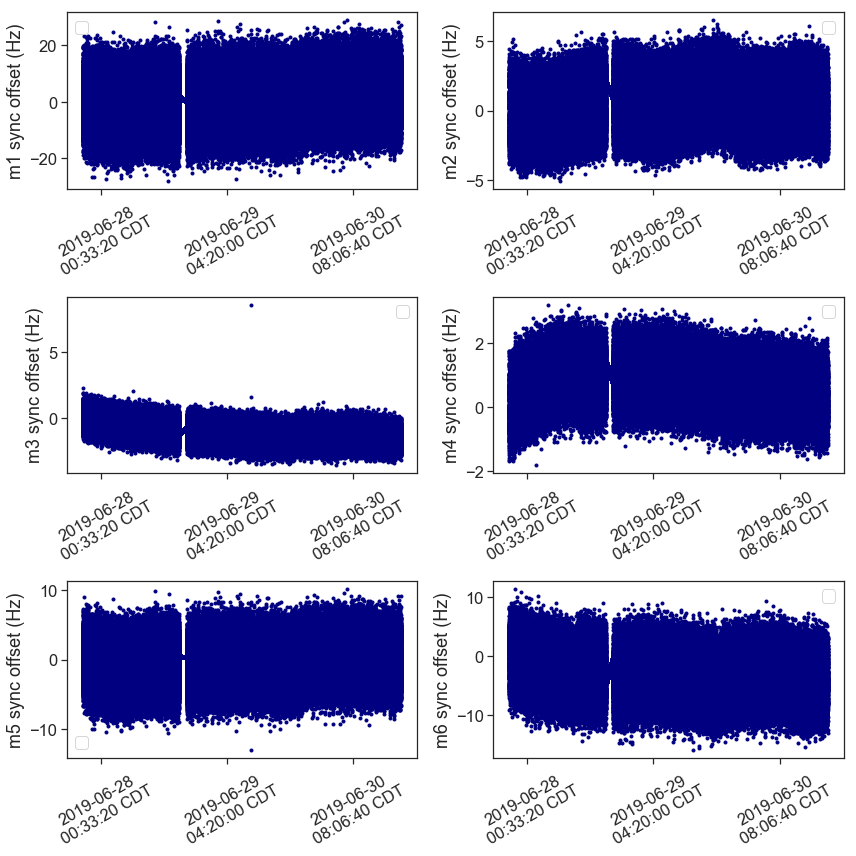

In [7]:
fig, axs = plt.subplots(3,2)
for ii in range(2):
    for jj in range(3):
        m = 2*jj+ii+1
        trm = 'tr,m'+str(m)
        stm = 'st'+str(st)+',m'+str(m)
        plt.sca(axs[jj,ii])
        plt.plot(vtm_df.index.values, vtm_df[stm]-moment_df[trm], '.', color='navy')
        plt2.plt_unix_time_to_CST(axs[jj,ii])
        plt2.plt_set_labels(axs[jj,ii], '', 'm'+str(m)+' sync offset (Hz)', '')
        plt.legend()
fig.set_size_inches(12,12)
fig.tight_layout()

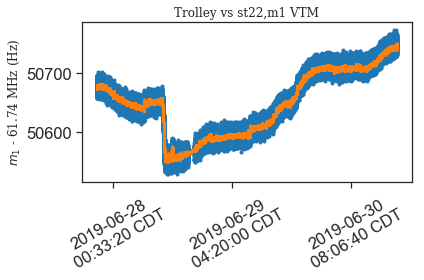

In [39]:
fig, ax = plt.subplots(1,1)

ax.plot(vtm_df.index.values, vtm_df['st22,m1'], '.', color='C0', label='vtm')
ax.plot(moment_df.index.values, moment_df['tr,m1'], '.', color='C1', markersize=3, label='trolley')

plt2.plt_unix_time_to_CST(ax)

ax.set_ylabel('$m_1$ - 61.74 MHz (Hz)', fontdict={'size':12, 'family':'serif'})
ax.set_title('Trolley vs st22,m1 VTM', fontdict={'size':12, 'family':'serif'})

fig.set_size_inches(6,4)
fig.tight_layout()

fig.savefig('super-long.png', dpi=300)

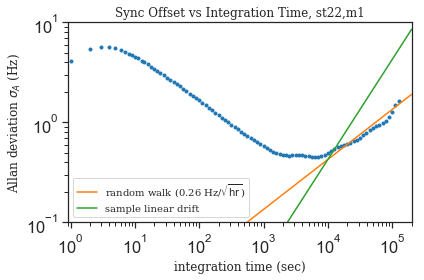

In [8]:
## calculate the allan deviation of the sync offset

fig, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.set_yscale('log')

taus_in = np.round(np.power(10, np.arange(0,5.5,0.05)))

taus, adev, _, _ = allantools.oadev((vtm_df['st22,m1']-moment_df['tr,m1']).values, data_type='freq', rate=1, taus=taus_in)
ax.plot(taus, adev, '.')

x_range = np.linspace(9e-1, 2e5, 1000)
y = (1/np.sqrt(55000)) * x_range**0.5
y2 = (1/np.sqrt(550000000)) * x_range

ax.plot(x_range, y, label='random walk (0.26 Hz/$\sqrt{\mathrm{hr}}$)')
ax.plot(x_range, y2, label='sample linear drift')

ax.set_ylim(0.1, 10)
ax.set_xlim(9e-1,2e5)

ax.set_xlabel('integration time (sec)', fontdict={'size':12, 'family':'serif'})
ax.set_ylabel('Allan deviation $\sigma_A$ (Hz)', fontdict={'size':12, 'family':'serif'})
ax.set_title('Sync Offset vs Integration Time, st22,m1', fontdict={'size':12, 'family':'serif'})

ax.legend(prop={'size':10, 'family':'serif'})

fig.set_size_inches(6,4)
fig.tight_layout()

# fig.savefig('super-long_allan.png', dpi=300)

In [32]:
A = (1/np.sqrt(55000))  # Hz per root sec

print A

print A * np.sqrt(3600/1)  # Hz per hour

print A * np.sqrt(3600/1) * 60

0.004264014327112209
0.25584085962673253
15.350451577603952


In [ ]:
### Bin into the agreed upon bins

bins = np.arange(vtm_df.index.values[0], vtm_df.index.values[-1], 1000)-500  # bin edges
bin_centers = np.arange(vtm_df.index.values[0], vtm_df.index.values[-1]-500, 1000)

vtm_bin_df = vtm_df.groupby(pd.cut(vtm_df.index, bins)).mean()
vtm_bin_df.index = bin_centers

moment_bin_df = moment_df.groupby(pd.cut(moment_df.index, bins)).mean()
moment_bin_df.index = bin_centers

test_df = vtm_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((test_df.shape[0],6)),
                         index = test_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

In [ ]:
print trfp.J_6_PROBE_OFFSET

print 

print trfp.J_4_PROBE

print trfp.J_4_PROBE_ST37_ST39

In [ ]:
fig2, ax2 = plt.subplots(1,1)
plt.plot(vtm_bin_df.index.values, vtm_bin_df['st22,m1'] - moment_bin_df['tr,m1'], '.', color='navy')
# plt.plot(moment_df.index.values, (moment_df['tr,m7']-moment_df['tr,m7'].iloc[0]), '.', color='orange', markersize=3, label='skew oct correction')
plt2.plt_unix_time_to_CST(ax2)
# plt2.plt_set_labels(ax2, '', '(Hz)', 'Next higher moment correction to skew quad')
plt.legend()
fig2.set_size_inches(8,6)
fig2.tight_layout()

In [ ]:
fig2, ax2 = plt.subplots(1,1)
plt.plot(vtm_df.index.values, vtm_df['st22,m3']-moment_df['tr,m3'], '.', color='navy', label='skew quad sync offset')
plt.plot(moment_df.index.values, -.55*(moment_df['tr,m7']-moment_df['tr,m7'].iloc[0]), '.', color='orange', markersize=3, label='skew oct correction')
plt2.plt_unix_time_to_CST(ax2)
plt2.plt_set_labels(ax2, '', '(Hz)', 'Next higher moment correction to skew quad')
plt.legend()
fig2.set_size_inches(8,6)
fig2.tight_layout()

In [ ]:
fig2, ax2 = plt.subplots(1,1)
plt.plot(vtm_df.index.values, vtm_df['st22,m1']-moment_df['tr,m1'], '.', color='navy', label='dipole sync offset')
plt.plot(moment_df.index.values, -3.5*(moment_df['tr,m8']-np.mean(moment_df['tr,m8'])), '.', color='orange', markersize=3, label='n dec correction')
plt2.plt_unix_time_to_CST(ax2)
plt2.plt_set_labels(ax2, '', '(Hz)', 'Next higher moment correction to dipole')
plt.legend()
fig2.set_size_inches(8,6)
fig2.tight_layout()

In [ ]:
# check the m6 sync offset adev and hdev

taus_in = np.round(np.power(10, np.arange(0,5.5,0.05)))

fig, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.set_yscale('log')

plt.sca(ax)
taus1, adev1, adev_err1, _ = allantools.oadev((fp_df['st22,m5'] - moment_df['tr,m5']).values, data_type='freq', rate=1, taus=taus_in)
plt.errorbar(taus1, adev1, yerr=adev_err1, fmt='.', color='orange', label='Allan deviation')
taus2, adev2, adev_err2, _ = allantools.ohdev((fp_df['st22,m5'] - moment_df['tr,m5']).values, data_type='freq', rate=1, taus=taus_in)
plt.errorbar(taus2, adev2, yerr=adev_err2, fmt='.', color='navy', label='Hadamard deviation')

plt.errorbar(taus1[0:88], adev1[0:88]-adev2, yerr=np.sqrt(adev_err1[0:88]**2 + adev_err2**2),
             fmt='.', color='green', label='Hadamard deviation')

plt.legend()

fig.set_size_inches(8,8)
fig.tight_layout()

In [ ]:
st = 22
m = 1
trm = 'tr,m'+str(m)
stm = 'st'+str(st)+',m'+str(m)

fig, axs = plt.subplots(2,1)
plt.sca(axs[0])
plt.plot(vtm_df.index.values, vtm_df[stm], '.', color='navy', label='vtm')
plt.plot(moment_df.index.values, moment_df[trm], '.', color='orange', label='trolley')
plt2.plt_set_labels(axs[0], '', 'm1 (Hz)', 'Dipole tracking')
plt2.plt_unix_time_to_CST(axs[0])
plt.legend()
plt.sca(axs[1])
plt.plot(moment_df.index.values, vtm_df[stm] - moment_df[trm], '.', color='orange', label='trolley')
plt2.plt_set_labels(axs[1], '', 'm1 sync offset (Hz)', 'Dipole sync offset')
plt2.plt_unix_time_to_CST(axs[1])

fig.set_size_inches(8,8)
fig.tight_layout()

# fig2, ax = plt.subplots(1,1)
# plt.sca(ax)
# plt.plot(moment_df['tr,m1'],  moment_df['st22,m1'], '.')
# fig2.set_size_inches(6,6)
# fig2.tight_layout()

taus_in = np.round(np.power(10, np.arange(0,5.5,0.05)))
taus_in2 = np.round(np.power(10, np.arange(0,7,0.05)))

fig3, ax2 = plt.subplots(1,1)
plt.sca(ax2)
ax2.set_xscale('log')
ax2.set_yscale('log')
taus, adev, adev_err, _ = allantools.oadev((vtm_df[stm] - moment_df[trm]).values, data_type='freq', rate=1, taus=taus_in)
plt.errorbar(taus, adev, yerr=adev_err, fmt='.', color='navy', label='with n 6-pole correction')
taus, adev, adev_err, _ = allantools.oadev((fp_df[stm] - moment_df[trm]).values, data_type='freq', rate=1, taus=taus_in)
plt.errorbar(taus, adev, yerr=adev_err, fmt='.', color='orange', label='no n 6-pole correction')
taus, adev, adev_err, _ = allantools.ohdev((fp_df[stm] - moment_df[trm]).values, data_type='freq', rate=1, taus=taus_in2)
plt.errorbar(taus, adev, yerr=adev_err, fmt='.', color='green', label='no n 6-pole correction, hdev')

# taus, adev, adev_err, _ = allantools.oadev((vtm_df[stm] - moment_df[trm] - 3.499*moment_df['tr,m8']).values, data_type='freq', rate=1, taus=taus_in)
# plt.errorbar(taus, adev, yerr=adev_err, fmt='.', color='red', label='add n 10-pole correction')

taus, adev, adev_err, _ = allantools.ohdev((vtm_df[stm] - moment_df[trm]).values, data_type='freq', rate=1, taus=taus_in2)
plt.errorbar(taus, adev, yerr=adev_err, fmt='.', color='red', label='with 6-pole, hdev')

ax2.legend()

ax2.set_title('Sync Offset Allan Plot')
ax2.set_xlabel(r'$\tau$ (sec)')
ax2.set_ylabel(r'$\sigma_a$ (Hz)')

fig3.set_size_inches(8,6)
fig3.tight_layout()

In [ ]:
fig, ax = plt.subplots(2,1)
plt.sca(ax[0])
plt.plot(moment_df.index.values, moment_df['st22,m1']-np.mean(moment_df['st22,m1']), '.', color='navy', label='fp dipole, no 6-pole')
plt.plot(moment_df.index.values, moment_df['tr,m1']-np.mean(moment_df['tr,m1']), '.', color='orange', markersize=3, label='tr dipole')
plt.legend()
plt2.plt_unix_time_to_CST(ax[0])
plt2.plt_set_labels(ax[0], '', 'm1 (Hz)', 'Dipole, no 6-pole correction')

plt.sca(ax[1])
plt.plot(moment_df.index.values, (moment_df['st22,m1']-np.mean(moment_df['st22,m1']))-(moment_df['tr,m1']-np.mean(moment_df['tr,m1'])), '.', color='navy')
plt2.plt_unix_time_to_CST(ax[1])
plt2.plt_set_labels(ax[1], '', 'm1 sync offset (Hz)', 'Dipole sync offset, no 6-pole correction')

fig.set_size_inches(8,8)
fig.tight_layout()

In [ ]:
taus, adev, adev_err, _ = allantools.ohdev((vtm_df[stm] - moment_df[trm]).values, data_type='freq', rate=1, taus=taus_in)
plt.errorbar(taus, adev, yerr=adev_err, fmt='.', color='navy')

plt.xscale('log')
plt.yscale('log')